# <font color=blue><div align="center"> **Projet Air France** </div></font>

### <font color=blue><div align="center">2023</div></font>

### <font color=peru>Group members (Groupe 1) :

- Justine Bourgeois
- Nathan Janiec
- Patrick Legendre
- Paul Massey
- Ivan Robert

</font>

# <font color=red>**Modelisation**</font>

We begin by optimizing seat assignements to group passengers on the same row. In second phase we refine this first optimization to ensure passengers are sitting next to each other on the same assigned rows.

The idea is to first solve the problem row-level problem by applying all constraint functions in the model alongside the objective function. The goal is maximise passenger satisfaction by grouping members of the same party on the same row and seating transit passengers in front seats of the plane.

In the second run, we solve a modified model, by removing some constraints (e.g., place the passengers in the same seating class), while adding others. For example, we ensure that the row assignments from the first phase remain unchanged.

## <font color=blue>Variables</font>
Since the first milestone, the modeling has been changed to improve the computation time of our model: we now consider binary variables in a matrix :
$$M = (x_{ij})_{i\ passengers,\ j\ seat}$$
$$x_{ij} =\left(\begin{matrix} 1\ if\ the\ passenger\ i\ is\ at\ seat\ j \\0\ else\end{matrix}\right.$$

## <font color=blue>Constraints</font>
### <font color=peru>Unique seat and passenger assignment</font>
Thus, for the uniqueness constraints of a passenger's seat assignment, it suffices that the sum of the passenger's row coefficients is equal to 1 (exactly one seat has been assigned).

Similarly, for the assignment of a passenger to a seat, the sum of the coefficients in the seat's column must be less than or equal to 1 (it has been assigned one passenger, or none if there are more passengers than seats).

### <font color = peru>Managing classes</font>

For the management of economy and business classes, the chosen method is to impose the following constraints: The number of passengers with a business ticket in economy class must be zero”, and ‘The number of passengers with an economy ticket in business class must be zero’.

To do this, we've chosen to represent it by a matrix calculation. We introduce a vector to filter seats, another to filter passengers, and we multiply the $M$ matrix containing the decision variables on either side. We introduce the vector $Ticket_B$, representing passengers with a business ticket:
$$Ticket_B = (Ticket_{B_i}),\ where\ Ticket_{B_i} = 1\ if\ the\ passenger\ i\ has\ a\ business\ ticket\ ,\ 0\ else$$

Similarly, we introduce the vector $Seat_{E}$, which represents economy class seats:

$$Seat_E = (Seat_{E_j}),\ where\ Seat_{E_i} = 1\ if\ the\ seat\ j\ is\ in\ economy\ class\,\ 0\ else$$

The product $M\times Seat_E$ represents a matrix whose coefficient at position $(i,j)$ is 1 if passenger $i$ has been allocated to seat $j$ and that seat is in economy class.

Thus, the scalar product $Ticket_B^\top\cdot (M\times Seat_E)$ represents the number of passengers with a business class ticket assigned to an economy class seat: the associated constraint is as follows:
$$Ticket_B^\top\cdot (M\times Seat_E) <= 0$$

We do the same for the opposite situation, replacing the 0s by 1s and the 1s by 0s in the vectors $Ticket_B$ and $Seat_E$.

 $Ticket_B^\top\cdot (M\times Seat_E)$ represents the number of passengers with a business class ticket assigned to an economy class seat: the associated constraint is as follows:
$$Ticket_B^\top\cdot (M\times Seat_E) <= 0$$

We do the same for the opposite situation, replacing the 0s by 1s and the 1s by 0s in the vectors $Ticket_B$ and $Seat_E$.

### <font color = peru>Passengers in Transit</font>
For transit passengers, we calculate the number $r_{\frac{1}{3}}$ of transit passengers in the first third of each class. To do this, we use two vectors: 
$$Transit = \left(transit_i\right),\ where\ transit_i = 1\ if\ the\ passenger\ i\ have\ a\ short\ transit,\ 0\ else$$

$$Front = \left(front_j\right),\ where\ front_j = 1\ if\ the\ seat\ j\ is\ in\ the\ first\ third\ of\ its\ class,\ 0\ else$$

The objective would then be to maximize the scalar product, which corresponds to the number of people in rapid transit (less than 90 minutes) whose seat is in the first third of their class:
$$r_\frac{1}{3} = Transit^\top\cdot (M\times Front)$$

### <font color = peru>Handling children passengers</font>
To force children to have an adult next to them, we impose:

$$\forall i \in [1;Number\_of\_ seats],  (Mat_{child,i} = 1 \implies \sum_{seat \in neighbour(i)} \sum_{adult \in group} Mat_{adult,seat} \geq 1) $$

with neighbors the indexes of neighboring seats to seat $i$

### <font color = peru>Handling people with reduced mobility</font>

To ensure that disabled people in wheelchairs (WCHR) are located according to the constraints, we require them to be in a space adjacent to the central aisle, and we create three fictitious people of zero mass for each WCHR, who are assigned to the spaces we wish to leave free. We'll refer to these fictitious people as “phantoms”.

To ensure that people on stretchers (WCHBs) are located according to the constraints, we require them to be placed in a middle row and prevent anyone from taking up the three seats in the front row, the individual's row and the two rows behind.

## <font color = blue>Objective function for the first model</font>

The aim of this first optimization is to place people in transit correctly and to place groups in the same row.
To do this, consider the following objective function:
$$min \sum_{g \in group}{(max\ \underset{i,j\in g}{dist_{row}}(i,j))}- r_\frac{1}{3}$$

## <font color = blue>Objective function for the second model</font>

In this second phase, transit passengers have already been placed and we are no longer trying to optimize according to rows, since we can no longer change the row allocated to a passenger. We'll then have the following objective function:
$$min \sum_{g \in group}{(max\ \underset{i,j\in g}{dist_{seat}}(i,j))}$$

# <font color=red>**Implementation**</font>

### Modules

In [128]:
# Base imports
import numpy as np
import pandas as pd
import random as rd
import time
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# Gurobi
from pyscipopt import Model, quicksum

### Usefull variables

In [129]:
number_of_rows = 30
nb_seats_in_row = 6
nb_of_seats = number_of_rows * nb_seats_in_row
limit = {'inf' : {'row' : number_of_rows//2 - 2,'seat' : 3}, 'sup' : {'row' : number_of_rows//2 + 2,'seat' : 4}}

### Data extraction from Excel

In [130]:
def extractExcel(filename):
    """
    fills a dictionnary with the data from the excel file
    """
    dataframe = pd.ExcelFile(filename)
    sheet_dict = {}
    i = 0
    for sheet_name in dataframe.sheet_names:
        sheet_dict.update({i: dataframe.parse(sheet_name)})
        i = i + 1
    return sheet_dict

def extractMinuteFromTransitTime(transit_time):
    """
    extracts the minutes from the transit time
    """
    minutes_in_hour = 60
    
    time = 0
    time = int(transit_time.hour * minutes_in_hour + transit_time.minute + transit_time.second / minutes_in_hour)
    
    return time

def createDicOfGroups(sheet_dict):
    """
    returns a dictionnary for each group, with the amount of passengers per category,
    the transit and the class
    """
    final_sheet = {}

    for i in range(0, len(sheet_dict)):
        temp_male = 0
        temp_female = 0
        temp_group_nr = 0
        time = 0
        temp_child = 0
        temp_WCHR = 0
        temp_WCHB = 0
        temp_ghost = 0
        Class = 0


        if sheet_dict['Numéro du groupe'][i].is_integer():
            temp_group_nr = sheet_dict['Numéro du groupe'][i]

        if  sheet_dict['Hommes'][i].is_integer() and temp_group_nr != 0:
            temp_male = sheet_dict['Hommes'][i]

        if sheet_dict['Femmes'][i].is_integer() and temp_group_nr != 0:
            temp_female = sheet_dict['Femmes'][i]

        if sheet_dict['Enfants'][i].is_integer() and temp_group_nr != 0:
            temp_child = sheet_dict['Enfants'][i]

        if sheet_dict['WCHR'][i].is_integer() and temp_group_nr != 0:
            temp_WCHR = sheet_dict['WCHR'][i]
            temp_ghost = 3

        if sheet_dict['WCHB'][i].is_integer() and temp_group_nr != 0:
            temp_WCHB = sheet_dict['WCHB'][i]

        if not isinstance(sheet_dict['TransitTime'][i], float):
            temptime = sheet_dict['TransitTime'][i]
            time = extractMinuteFromTransitTime(temptime)
        
        if isinstance(sheet_dict['Classe'][i], str): # Business class = 1, Economy class = 0
            tempclass = sheet_dict['Classe'][i]
            if tempclass == "J":
                Class = 1
            elif tempclass == "Y":
                Class = 0

        if temp_group_nr != 0:
            final_sheet.update({int(temp_group_nr-1) : 
                                {'h' : int(temp_male), 'f' : int(temp_female), 'c' : int(temp_child), 
                                 'WCHR' : int(temp_WCHR), 
                                 'WCHB' : int(temp_WCHB), 'g': int(temp_ghost), 
                                 'transit_time' : time, 'class' : Class}})

    return final_sheet

def createDicOfPassengers(sheet_dict):
    """
    returns a dict that stores passengers and each passenger has a category,
    transit time, the group number and the class.
    """
    final_sheet = {}

    index = 0
    Class = 0
    for i in range(0, len(sheet_dict)): # We iterate on each group present in the excel table
        temp_group_nr = 0 # each passenger has a group number

        if sheet_dict['Numéro du groupe'][i].is_integer(): 
            temp_group_nr = sheet_dict['Numéro du groupe'][i]

        if not isinstance(sheet_dict['TransitTime'][i], float):
            temptime = sheet_dict['TransitTime'][i]
            time = extractMinuteFromTransitTime(temptime)
        
        if isinstance(sheet_dict['Classe'][i], str):
            tempclass = sheet_dict['Classe'][i]
            if tempclass == "J":
                Class = 1
            elif tempclass == "Y":
                Class = 0

        if  sheet_dict['Hommes'][i].is_integer() and temp_group_nr != 0:
            temp_male = sheet_dict['Hommes'][i]
            for j in range(0, int(temp_male)): # We store all information about the mens in the group
                final_sheet.update({index: {'cat': 'h', 'transit_time' : time, 
                                            'groupnr' : int(temp_group_nr-1), 'class' : Class}})
                index += 1

        if sheet_dict['Femmes'][i].is_integer() and temp_group_nr != 0:
            temp_female = sheet_dict['Femmes'][i]
            for j in range(0, int(temp_female)): # We store all information about the females in the group
                final_sheet.update({index: {'cat': 'f', 'transit_time' : time, 
                                            'groupnr' : int(temp_group_nr-1), 'class' : Class}})
                index += 1

        if sheet_dict['Enfants'][i].is_integer() and temp_group_nr != 0:
            temp_child = sheet_dict['Enfants'][i]
            for j in range(0, int(temp_child)):# We store all information about the children in the group
                final_sheet.update({index: {'cat': 'e', 'transit_time' : time, 
                                            'groupnr' : int(temp_group_nr-1), 'class' : Class}})
                index += 1
        
        if sheet_dict['WCHR'][i].is_integer() and temp_group_nr != 0:
            temp_WCHR = sheet_dict['WCHR'][i]
            for j in range(0, int(temp_WCHR)):# We store all information about the WCHR in the group
                final_sheet.update({index: {'cat': 'WCHR', 'transit_time' : time, 
                                            'groupnr' : int(temp_group_nr-1), 'class' : Class}})
                index += 1
                for i in range(0, 3):# ghost (a ghost is a passenger arround the WCHR)
                    final_sheet.update({index: {'cat' : 'g', 'transit_time' : 0, 
                                            'groupnr' : int(temp_group_nr-1), 'class' : Class}})
                    index += 1
        
        if sheet_dict['WCHB'][i].is_integer() and temp_group_nr != 0:
            temp_WCHB = sheet_dict['WCHB'][i]
            for j in range(0, int(temp_WCHB)):# We store all information about the WCHB in the group
                final_sheet.update({index: {'cat': 'WCHB', 'transit_time' : time, 
                                            'groupnr' : int(temp_group_nr-1), 'class' : Class}})
                index += 1

    return final_sheet


def mass(index, passenger_sheet):
    """returns the passenger mass according to his category"""
    if passenger_sheet[index]['cat']=='h':
        return 90
    if passenger_sheet[index]['cat']=='f':
        return 70
    if passenger_sheet[index]['cat']=='e':
        return 50
    if passenger_sheet[index]['cat']=='WCHR':
        return 15 + 80
    if passenger_sheet[index]['cat']=='WCHB':
        return 80
    if passenger_sheet[index]['cat']=='g':
        return 0

### Selection of instances

In [131]:
file = "Data/DataSeating.xlsx"

sheet_dict = extractExcel(file)

n = 3
# To choose an instance, you can change n =[0-8]
first_sheet = sheet_dict[n]

group_sheet = createDicOfGroups(first_sheet)

passenger_sheet = createDicOfPassengers(first_sheet)

### Vector generation for certain constraints

In [132]:
def length_of_group(g):
    amount = g['h'] + g['f'] + g['c'] + g['WCHR'] + g['WCHB']
    return amount


def obtain_vector_passenger_seats(nb_of_seats,nb_business_seat):
    n=1
    vector=np.zeros(nb_of_seats,dtype=int)
    for i in range (nb_of_seats):
        if i < nb_business_seat:
            vector[i] = n
            if n == 5:
                n=1
            elif n==2:
                n=4
            else:
                n+=1
        else:
            vector[i]=n
            if n==7:
                n=1
            elif n==3:
                n=5
            else:
                n+=1
    return vector

def obtain_vector_passenger_seats_bary(nb_of_seats,nb_business_seat):
    n=1
    vector=np.zeros(nb_of_seats,dtype=int)
    for i in range (nb_of_seats):
        if i < nb_business_seat:
            vector[i] = n
            if n == 7:
                n=1
            else:
                n+=2
        else:
            vector[i]=n
            if n==7:
                n=1
            elif n==3:
                n=5
            else:
                n+=1
    return vector

def obtain_vector_passenger_rows(nb_of_seats,nb_business_seat):
    n=1
    row=1
    vector=np.zeros(nb_of_seats,dtype=int)
    for i in range (nb_of_seats):
        if i < nb_business_seat:
            vector[i]=row
            n+=1
            if n==5:
                n=1
                row+=1
        else:
            vector[i]=row
            n+=1
            if n==7:
                n=1
                row+=1
    return vector

def seat_to_pair(seat,nb_business_seat):
    """
    Returns the pair of seats associated with the seat number seat
    Used to display the seat numbers
    """
    if seat < nb_business_seat:
        a,b = seat//4 + 1, seat % 4 + 1
        b = 2*b -1
    else:
        seat -= nb_business_seat
        a,b = seat//nb_seats_in_row + 1 + nb_business_seat//4, seat % nb_seats_in_row + 1
        if b >= 4:
            b += 1    
    return (a,b)




# Transit functions
def obtain_vector_passenger_front(nb_of_seats,nb_business_seat):
    n=1
    vector=np.zeros(nb_of_seats,dtype=int)
    EcoSeats = nb_of_seats - nb_business_seat
    for i in range(((nb_business_seat//4)//3)*4):
        vector[i] = 1
    for i in range(((EcoSeats//nb_seats_in_row)//3)*nb_seats_in_row):
        vector[nb_business_seat + i] = 1
    return vector

def obtain_transit_vector(passenger_sheet):
    vector = np.zeros(len(passenger_sheet),dtype=int)
    for i in range(len(vector)):
        if passenger_sheet[i]['transit_time'] <= 90 and passenger_sheet[i]['transit_time'] > 0:
            vector[i] = 1
    return vector

# Classes functions
def get_number_of_business_seats(passenger_sheet):
    nb_business_seat = 0
    for i in range(len(passenger_sheet)):
        if passenger_sheet[i]['class']:
            nb_business_seat += 1
    return (nb_business_seat//4 + 1) * 4

def obtain_class_vector(passenger_sheet):
    vector = np.zeros(len(passenger_sheet),dtype = int)
    for i in range(len(vector)):
        if passenger_sheet[i]['class']:
            vector[i] = 1
    return vector

def obtain_eco_class_vector(nb_of_seats,nb_business_seat):
    vector = np.zeros(nb_of_seats,dtype = int)
    for i in range(nb_business_seat,nb_of_seats):
        vector[i] = 1
    return vector

In [133]:
def nb_seats_in_plane(plane_type,nb_business_seat):
    if plane_type=="A320":
        nb_rows=30
    else:
        nb_rows=37
    nb_business_rows=nb_business_seat//4
    return nb_business_rows*4+(nb_rows-nb_business_rows)*6

def plane_type_choice(group_sheet,nb_business_seat):
    nb_seats_nec=0
    for i in group_sheet.keys():
        nb_seats_nec += group_sheet[i]['h']+group_sheet[i]['f']+group_sheet[i]['g']+group_sheet[i]['c']+group_sheet[i]['WCHR']+12*group_sheet[i]['WCHB']
    if nb_seats_nec>nb_seats_in_plane("A321",nb_business_seat):
        print("there is not enough seats in the plane")
    elif nb_seats_nec>nb_seats_in_plane("A320",nb_business_seat):
        return "A321"
    else:
        return "A320"
    
def plane_rows(plane_type):
    if plane_type=="A320":
        return 30
    else:
        return 37 
    
def barycentre_zone_plane(plane_type):
    if plane_type=="A320":
        return {'inf' : {'row' : 13,'seat' : 3}, 'sup' : {'row' : 17,'seat' : 5}}
    else:
        return {'inf' : {'row' : 16,'seat' : 3}, 'sup' : {'row' : 21,'seat' : 5}}

def emergency_exit_plane(plane_type):
    if plane_type=="A320":
        return [11,12]
    else:
        return [10,25]

In [134]:
nb_passengers = len(list(passenger_sheet))
nb_business_seat = get_number_of_business_seats(passenger_sheet)
nb_of_seats = nb_business_seat + (number_of_rows - nb_business_seat//4) * nb_seats_in_row

plane=plane_type_choice(group_sheet,nb_business_seat)
nb_rows=plane_rows(plane)
nb_of_seats = nb_business_seat + (nb_rows - nb_business_seat//4) * 6
number_of_rows = nb_rows


limit = barycentre_zone_plane(plane)
emergency_exit=emergency_exit_plane(plane)

### Defining the model and variables

In [135]:
nb_passengers = len(list(passenger_sheet))
nb_business_seat = get_number_of_business_seats(passenger_sheet)
nb_of_seats = nb_business_seat + (number_of_rows - nb_business_seat//4) * nb_seats_in_row

m = Model("Modele 1")

rho = {g:m.addVar(name = f"rho_{g}") for g in range(len(group_sheet))}

mat = [[m.addVar(vtype="B", name=f"mat_{i}_{j}") for j in range(nb_of_seats)] for i in range(nb_passengers)]


C:\Users\pathe\AppData\Local\Temp\ipykernel_12720\3609350386.py:5: UserWarning: linked SCIP 9.02 is not recommended for this version of PySCIPOpt - use version 9.2.1
  m = Model("Modele 1")


### Single-space constraints

In [136]:
vector_seat=obtain_vector_passenger_seats(nb_of_seats,nb_business_seat)
vector_rows=obtain_vector_passenger_rows(nb_of_seats,nb_business_seat)
vector_seat_bary = obtain_vector_passenger_seats_bary(nb_of_seats,nb_business_seat)

def fseat(id_passenger):
    return vector_seat@mat[id_passenger]
    

def frow(id_passenger):
    return vector_rows@mat[id_passenger]

def fseatbary(id_passenger):
    return vector_seat_bary@mat[id_passenger]

# Constraint: single seat/passenger
for i in range(nb_passengers):
    m.addCons(quicksum(mat[i]) == 1)
for j in range(nb_of_seats):
    m.addCons(quicksum(mat[i][j] for i in range(nb_passengers)) <= 1)

### Transit management

In [137]:
vector_front = obtain_vector_passenger_front(nb_of_seats,nb_business_seat)
transit_vector = obtain_transit_vector(passenger_sheet)

def transit_front():
    return (transit_vector@mat)@vector_front

r1_3 = transit_front()

### Class constraints

In [138]:
class_vector = obtain_class_vector(passenger_sheet)
eco_vector = obtain_eco_class_vector(nb_of_seats,nb_business_seat)

def bad_placed_business():
    return class_vector@mat@eco_vector

def bad_placed_eco():
    opposed_class_vector = np.ones(len(passenger_sheet),dtype = int) - class_vector
    business_vector = np.ones(nb_of_seats,dtype = int) - eco_vector
    return opposed_class_vector@mat@business_vector

m.addCons(bad_placed_business() <= 0)
m.addCons(bad_placed_eco() <= 0)

c344

### Barycenter constraint

In [139]:
mass_sum = quicksum([mass(i, passenger_sheet) for i in passenger_sheet])

BaryInfRow = m.addCons(quicksum(frow(i) * mass(i, passenger_sheet) for i in passenger_sheet) >= limit['inf']['row'] * mass_sum)
BarySupRow = m.addCons(quicksum(frow(i) * mass(i, passenger_sheet) for i in passenger_sheet) <= limit['sup']['row'] * mass_sum)
BaryInfSeat = m.addCons(quicksum(fseatbary(i) * mass(i, passenger_sheet) for i in passenger_sheet) <= limit['sup']['seat'] * mass_sum)
BarySupSeat = m.addCons(quicksum(fseatbary(i) * mass(i, passenger_sheet) for i in passenger_sheet) >= limit['inf']['seat'] * mass_sum)

### Group proximity management

In [140]:
for g in rho:
    if(length_of_group(group_sheet[g]) == 1):
        m.addCons(rho[g] == 0)
    else:
        for i in passenger_sheet:
            if passenger_sheet[i]['groupnr'] == g:
                for j in passenger_sheet:
                    if passenger_sheet[j]['groupnr'] == g:
                        m.addCons(rho[g] >= frow(i) - frow(j))
                        m.addCons(rho[g] >= frow(j) - frow(i))

In [141]:
def neighbours(id_seat):
    """
    Returns the list of seat indices immediately right/left according to existence
    """
    seat = vector_seat[id_seat]

    if seat == 1:
        return [id_seat + 1]
    elif seat == 7:
        return [id_seat - 1]
    else:
        return [id_seat - 1, id_seat + 1]

def neighbours_rows(id_seat):
    return [seat for seat in range(len(vector_rows)) if vector_rows[seat]==vector_rows[id_seat]]

def neighbours_fantoms(id_seat):
    """
    Returns the list of seats where fictitious passengers are seated around a wheelchair
    """
    seat = vector_seat[id_seat]

    if seat == 3:
        return [id_seat-nb_seats_in_row-1,id_seat-nb_seats_in_row,id_seat-1]
    elif seat == 5:
        return [id_seat - nb_seats_in_row,id_seat-nb_seats_in_row+1,id_seat+1]
    else:
        return []

def neighbour_stretchers(id_seat):
    """"
    Returns the list of seats left empty by the presence of a stretcher at index id_siege
    """
    row = vector_rows[id_seat]
    seat = vector_seat[id_seat]
    if seat >= number_of_rows - 2 or row <= nb_business_seat//4 + 1 or not seat in [2,nb_seats_in_row]:
        return []
    else:
        return [id_seat - nb_seats_in_row-1, id_seat-nb_seats_in_row,id_seat-nb_seats_in_row+1,id_seat-1,id_seat+1,id_seat+nb_seats_in_row-1,id_seat+nb_seats_in_row,id_seat+nb_seats_in_row+1,id_seat+2*nb_seats_in_row-1,id_seat+2*nb_seats_in_row,id_seat+2*nb_seats_in_row+1]

def ischild(index, passenger_sheet):
    return passenger_sheet[index]['cat']=='e'

def isWCHR(index, passenger_sheet):
    return passenger_sheet[index]['cat']=='WCHR'

def isfantom(index, passenger_sheet):
    return passenger_sheet[index]['cat']=='g'

def isWCHB(index, passenger_sheet):
    return passenger_sheet[index]['cat']=='WCHB' 

### Children and passengers with reduced mobility

In [142]:
parents = {}                        # dictionary with index = child identifier and value = list of adults in the group
fantoms = {}                       # dictionary with index = identifier of a WCHR and value = list of fictitious passengers in the group
stretchers = []                       # list stretcher passenger
groups = {}                         # dictionary with index = group index and value = (dictionary with index = identifier of an individual in the group and value = characteristics of the individual)

for child in passenger_sheet:
    if ischild(child,passenger_sheet):
        for id_seat in range(nb_of_seats):
                if vector_rows[id_seat] in [11,12]:       # not near an emergency exit
                    m.addCons(mat[child][id_seat] <= 0)
                    

for group in group_sheet:
    groups[group] = {}
    for passenger in passenger_sheet:
           if passenger_sheet[passenger]['groupnr'] == group:
                groups[group][passenger] = passenger_sheet[passenger]

for group in group_sheet:
    for individual in groups[group]:
        if ischild(individual, passenger_sheet) and len([person for person in groups[group] if not isWCHB(person, passenger_sheet)]) != 1:
            if len([child for child in groups[group] if ischild(child, passenger_sheet)]) <= 2*len([adult for adult in groups[group] if not ischild(adult, passenger_sheet)]):
                parents[individual] = [adult for adult in groups[group] if not ischild(adult, passenger_sheet)]
            else:
                parents[individual] = [person for person in groups[group] if person != individual]

        if isWCHR(individual,passenger_sheet):
            fantoms[individual] = [fantom for fantom in groups[group] if isfantom(fantom, passenger_sheet)]
        if isWCHB(individual,passenger_sheet):
            stretchers.append(individual)


for child in parents:                               # at least one adult must stand next to each child
    for id_seat in range(nb_of_seats):
        m.addCons(quicksum(quicksum(mat[parent][neighbour] for neighbour in neighbours_rows(id_seat)) for parent in parents[child]) >= mat[child][id_seat])

for handicap in fantoms:                          # the position of the fictitious passengers around a WCHR and their positioning on the central aisle
    for id_seat in range(nb_of_seats):
        if not vector_seat[id_seat] in [3,5]:
           m.addCons(mat[handicap][id_seat] <= 0)
        else:
            m.addCons(quicksum(quicksum(mat[fantom][neighbour] for neighbour in neighbours_fantoms(id_seat)) for fantom in fantoms[handicap]) >= 3 * mat[handicap][id_seat])

for WCHB in stretchers:                               # the four rows corresponding to a WCHB must be free.
    for pos_WCHB in range(nb_of_seats):
        row = vector_rows[pos_WCHB]
        seat = vector_seat[pos_WCHB]
        if row >= number_of_rows - 2 or row <= nb_business_seat//4 + 1 or seat not in [2,nb_seats_in_row]:
            m.addCons(mat[WCHB][pos_WCHB] <= 0) 
        else:
            for passager in range(nb_passengers):
                for id_seat in neighbour_stretchers(pos_WCHB):
                    m.addCons(1 - mat[passager][id_seat] >= mat[WCHB][pos_WCHB])
            for WCHB2 in stretchers:
                m.addCons(1 - mat[WCHB2][pos_WCHB + 3 * nb_seats_in_row] >= mat[WCHB][pos_WCHB])

### Objective function

In [143]:
dist_sum = quicksum(rho[g] / length_of_group(group_sheet[g]) for g in group_sheet) - r1_3
m.setObjective(dist_sum, "minimize")

### Optimization

In [156]:
import time
correction_needed = False # Will become True if the time limit is reached on one of the two optimizations

m.setParam("display/verblevel", 4) # 0 = silent, 4 = detailed
limit1 = 15*60
m.setParam("limits/time", limit1)   

start_1 = time.time()
print(" --- start of optimization --- ")
m.optimize()
end_1 = time.time()
correction_needed = correction_needed or (end_1-start_1)>=0.95*limit1

# dict_attributions[i] gives (rank,place) of passenger i
dict_attributions = dict()

# Filling dict_attributions
if m.getStatus() == "infeasible":
    print(m.printStats(), "\n\tHAS NO SOLUTION!!!")
elif m.getStatus() == "unbounded":
    print(m.printStats(), "\n\tUNBOUNDED TEST!!!")
else:
    for i in range(nb_passengers):
        for j in range(nb_of_seats):
            if m.getVal(mat[i][j]) > 0.5:
                (row,seat) = seat_to_pair(j, nb_business_seat)
                dict_attributions[i] = (row,seat)

 --- start of optimization --- 


### Display

In [159]:
def create_dict_display(dict_attributions):
    dict_display=dict()
    for i in dict_attributions:
        if passenger_sheet[i]['groupnr'] not in dict_display:
            dict_display[passenger_sheet[i]['groupnr']] = dict()
        dict_display[passenger_sheet[i]['groupnr']][i] = (dict_attributions[i][0], dict_attributions[i][1])
    return dict_display


def display_positions(dict_display):
    plt.figure(figsize=(24,6))
    solo_rows = []
    solo_seats = []
    for group in dict_display:
        if length_of_group(group_sheet[group]) > 1:
            rows = []
            seats = []
            for i in dict_display[group]:
                rows.append(number_of_rows - dict_display[group][i][0])
                seats.append(dict_display[group][i][1])
                if passenger_sheet[i]['cat']=='f':
                    color = 'red' if group_sheet[group]['transit_time'] >0 and group_sheet[group]['transit_time'] <= 90 else "black"
                else:
                    color = 'orange' if group_sheet[group]['transit_time'] >0 and group_sheet[group]['transit_time'] <= 90 else "darkblue"
                fs = 'small' if group_sheet[group]['class'] == 1 else "x-large"
                fw = 'normal'
                position = [dict_display[group][i][0],dict_display[group][i][1]]
                if ischild(i, passenger_sheet):
                    text = str(group)
                    fw = 'black'
                elif isWCHR(i, passenger_sheet):
                    text = str(group)
                    if position[1]>3:
                        plt.plot([position[0]-1, position[0]+0.75, position[0]+0.75, position[0]-1,position[0]-1],[position[1]+1.5,position[1]+1.5, position[1]-0.25,position[1]-0.25,position[1]+1.5],'-',c='green')
                    else:
                        plt.plot([position[0]-1, position[0]+0.75, position[0]+0.75, position[0]-1,position[0]-1],[position[1]-1.25,position[1]-1.25, position[1]+0.5,position[1]+0.5,position[1]-1.25],'-',c='green')
                elif isfantom(i,passenger_sheet):
                    text = ""
                elif isWCHB(i,passenger_sheet):
                    text = str(group)
                    plt.plot([position[0]-1.25, position[0]+2.75, position[0]+2.75, position[0]-1.25,position[0]-1.25],[position[1]+1.5,position[1]+1.5, position[1]-1.25,position[1]-1.25,position[1]+1.5],'-',c='purple')
                else:
                    text = str(group)
                plt.text(position[0],position[1],text,fontsize=fs,c=color,fontweight = fw)
        else:
            for i in dict_display[group]:
                solo_rows.append(number_of_rows - dict_display[group][i][0])
                solo_seats.append(dict_display[group][i][1])
                if passenger_sheet[i]['cat']=='f':
                    color = 'red' if group_sheet[group]['transit_time'] >0 and group_sheet[group]['transit_time'] <= 90 else "darkblue"
                else:
                    color = 'orange' if group_sheet[group]['transit_time'] >0 and group_sheet[group]['transit_time'] <= 90 else "black"
                fs = 'small' if group_sheet[group]['class'] == 1 else "x-large"
                fw = 'normal'
                position = [dict_display[group][i][0],dict_display[group][i][1]]
                if ischild(i, passenger_sheet):
                    text = "X"
                    fw = 'black'
                elif isWCHR(i, passenger_sheet):
                    text = "h"
                    if position[1]>3:
                        plt.plot([position[0]-1, position[0]+0.75, position[0]+0.75, position[0]-1,position[0]-1],[position[1]+1.5,position[1]+1.5, position[1]-0.25,position[1]-0.25,position[1]+1.5],'-',c='green')
                    else:
                        plt.plot([position[0]-1, position[0]+0.75, position[0]+0.75, position[0]-1,position[0]-1],[position[1]-1.25,position[1]-1.25, position[1]+0.5,position[1]+0.5,position[1]-1.25],'-',c='green')
                elif isfantom(i,passenger_sheet):
                    text = ""
                elif isWCHB(i,passenger_sheet):
                    text = "b"
                    plt.plot([position[0]-1.25, position[0]+2.75, position[0]+2.75, position[0]-1.25,position[0]-1.25],[position[1]+1.5,position[1]+1.5, position[1]-1.25,position[1]-1.25,position[1]+1.5],'-',c='purple')
                else:
                    text = "X"
                plt.text(position[0],position[1],text,fontsize=fs,c=color,fontweight = fw)

    plt.scatter([-4,number_of_rows + 1], [0,8],c="white")
    barycentre_seat = sum([sum([dict_display[group][i][1]*mass(i, passenger_sheet) for i in dict_display[group]]) for group in dict_display])/sum([mass(i, passenger_sheet) for i in passenger_sheet])
    barycentre_row = sum([sum([dict_display[group][i][0]*mass(i, passenger_sheet) for i in dict_display[group]]) for group in dict_display])/sum([mass(i, passenger_sheet) for i in passenger_sheet])
    print(f"the barycentre is at rank {barycentre_row} and in seat {barycentre_seat}")
    plt.scatter([barycentre_row],[barycentre_seat], label = "barycentre")


    x_eco_busi = nb_business_seat//4 + 1/2
    plt.plot([x_eco_busi,x_eco_busi],[0,7.5],'-',label = "Business/Eco")
    plt.plot([emergency_exit[0]-0.25,emergency_exit[0]+0.75],[0.8,0.8],'-',c='red',label='Emergency Exit')
    plt.plot([emergency_exit[0]-0.25,emergency_exit[0]+0.75],[7.5,7.5],'-',c='red')
    plt.plot([emergency_exit[1]-0.25,emergency_exit[1]+0.75],[0.8,0.8],'-',c='red')
    plt.plot([emergency_exit[1]-0.25,emergency_exit[1]+0.75],[7.5,7.5],'-',c='red')


    plt.legend()
    plt.show()

the barycentre is at rank 15.217532467532468 and in seat 3.699675324675325


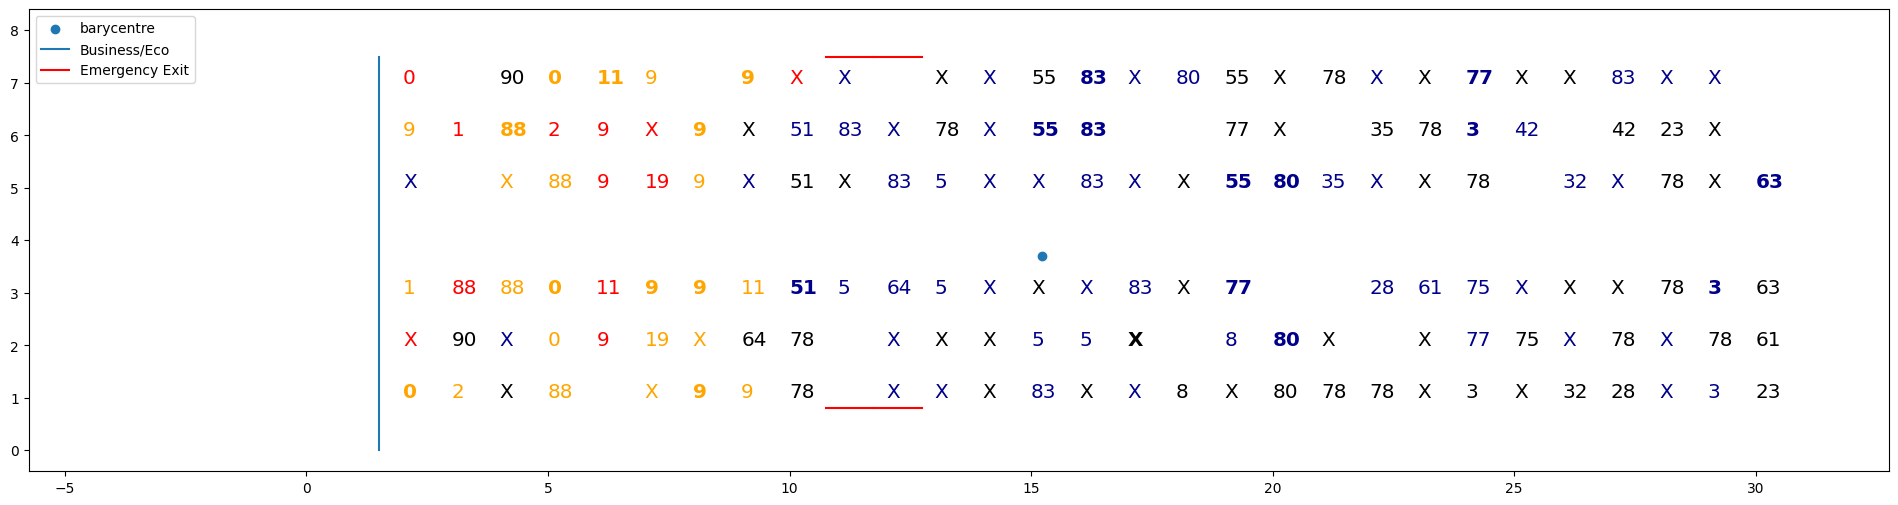

In [160]:
display_positions(create_dict_display(dict_attributions))

## Second model with variables and constraints

In [161]:
m2 = Model("Modele 2")
mat = [[m2.addVar(vtype="B", name=f"mat_{i}_{j}") for j in range(nb_of_seats)] for i in range(nb_passengers)]
rho_p = {g: m2.addVar(vtype="C", lb=0, name=f"rho_p_{g}") for g in range(len(groups))}


# single passenger seat
for i in range(nb_passengers):
    m2.addCons(quicksum(mat[i]) == 1)
for j in range(nb_of_seats):
    m2.addCons(quicksum(mat[i][j] for i in range(nb_passengers)) <= 1)


# Integration of the result of the first optimization
for i in range(nb_passengers):
    m2.addCons(frow(i) == dict_attributions[i][0])

# Place people from the same group in the same row
for g in range(len(groups)):
    if(length_of_group(group_sheet[g]) == 1):
        m2.addCons(rho_p[g] == 0)
    else:
        for i in range(nb_passengers):
            if passenger_sheet[i]['groupnr'] == g:
                for j in range(i+1,nb_passengers):
                    if passenger_sheet[j]['groupnr'] == g:
                        if (ischild(i, passenger_sheet) and not ischild(j, passenger_sheet)) or (ischild(j, passenger_sheet) and not ischild(i, passenger_sheet)):
                            m2.addCons(rho_p[g] >= 2 * (fseat(i) - fseat(j)))
                            m2.addCons(rho_p[g] >= 2 * (fseat(j) - fseat(i)))
                        else:
                            m2.addCons(rho_p[g] >= fseat(i) - fseat(j))
                            m2.addCons(rho_p[g] >= fseat(j) - fseat(i))


mass_sum = quicksum(mass(i, passenger_sheet) for i in passenger_sheet)

# Barycenter constraint
BaryInfRow = m2.addCons(quicksum(frow(i) * mass(i, passenger_sheet) for i in passenger_sheet) >= limit['inf']['row'] * mass_sum)
BarySupRow = m2.addCons(quicksum(frow(i) * mass(i, passenger_sheet) for i in passenger_sheet) <= limit['sup']['row'] * mass_sum)
BaryInfSeat = m2.addCons(quicksum(fseat(i) * mass(i, passenger_sheet) for i in passenger_sheet) <= limit['sup']['seat'] * mass_sum)
BarySupSeat = m2.addCons(quicksum(fseat(i) * mass(i, passenger_sheet) for i in passenger_sheet) >= limit['inf']['seat'] * mass_sum)

for child in parents:                               # at least one adult must stand next to each child
    for id_seat in [id_seat for id_seat in range(nb_of_seats) if vector_rows[id_seat]==dict_attributions[child][0]]:
        m2.addCons(quicksum(quicksum(mat[parent][neighbour] for neighbour in neighbours(id_seat)) for parent in parents[child]) >= mat[child][id_seat])


for handicap in fantoms:                          # the position of the fictitious passengers around a WCHR and their positioning on the central aisle
    for id_seat in range(nb_of_seats):
        if not vector_seat[id_seat] in [3,5]:
            m2.addCons(mat[handicap][id_seat] <= 0)
        else:
            m2.addCons(quicksum(quicksum(mat[fantom][neighbour] for neighbour in neighbours_fantoms(id_seat)) for fantom in fantoms[handicap]) >= 3 * mat[handicap][id_seat])

for WCHB in stretchers:                               # the four rows corresponding to a WCHB must be free.
    for pos_WCHB in [seat for seat in range(nb_of_seats) if vector_rows[seat] == dict_attributions[WCHB][0]]:
        seat = vector_seat[pos_WCHB]
        if seat not in [2,nb_seats_in_row]:
            m2.addCons(mat[WCHB][pos_WCHB] <= 0)
        else:
            for passager in [people for people in dict_attributions if dict_attributions[people][0] - dict_attributions[WCHB][0] in [-1,0,1,2]]:
                for id_siege in neighbour_stretchers(pos_WCHB):
                    m2.addCons(1 - mat[passager][id_siege] >= mat[WCHB][pos_WCHB])
            for WCHB2 in stretchers:
                m2.addCons(1 - mat[WCHB2][pos_WCHB + 3 * nb_seats_in_row] >= mat[WCHB][pos_WCHB])


# Objective function
dist_sum = quicksum(rho_p[g] / len(groups[g]) for g in rho_p)
m2.setObjective(dist_sum, "minimize")

C:\Users\pathe\AppData\Local\Temp\ipykernel_12720\2118580706.py:1: UserWarning: linked SCIP 9.02 is not recommended for this version of PySCIPOpt - use version 9.2.1
  m2 = Model("Modele 2")


KeyError: 28

## Optimizing the second model

In [ ]:
m2.setParam("display/verblevel", 4) # 0 = limited, 4 = detailed
limit2 = 8*60
m2.setParam("limits/time", limit1)

start_2 = time.time()
print(" --- start of optimization --- ")
m2.optimize()
end_2 = time.time()

correction_needed = correction_needed or (end_2-start_2)>=0.95*limit2

# dict_attributions[i] gives (row,seat) of passenger i
dict_attributions = dict()

# Filling dict_attributions
if m2.getStatus() == "infeasible":
    print("the model has no solution")
elif m2.getStatus() == "unbounded":
    print("the model is unbounded")
else:
    for i in range(nb_passengers):
        for j in range(nb_of_seats):
            if m2.getVal(mat[i][j]) > 0.5:
                (row,seat) = seat_to_pair(j, nb_business_seat)
                dict_attributions[i] = (row,seat)

### Display

the barycentre is at rank 0.0 and in seat 0.0


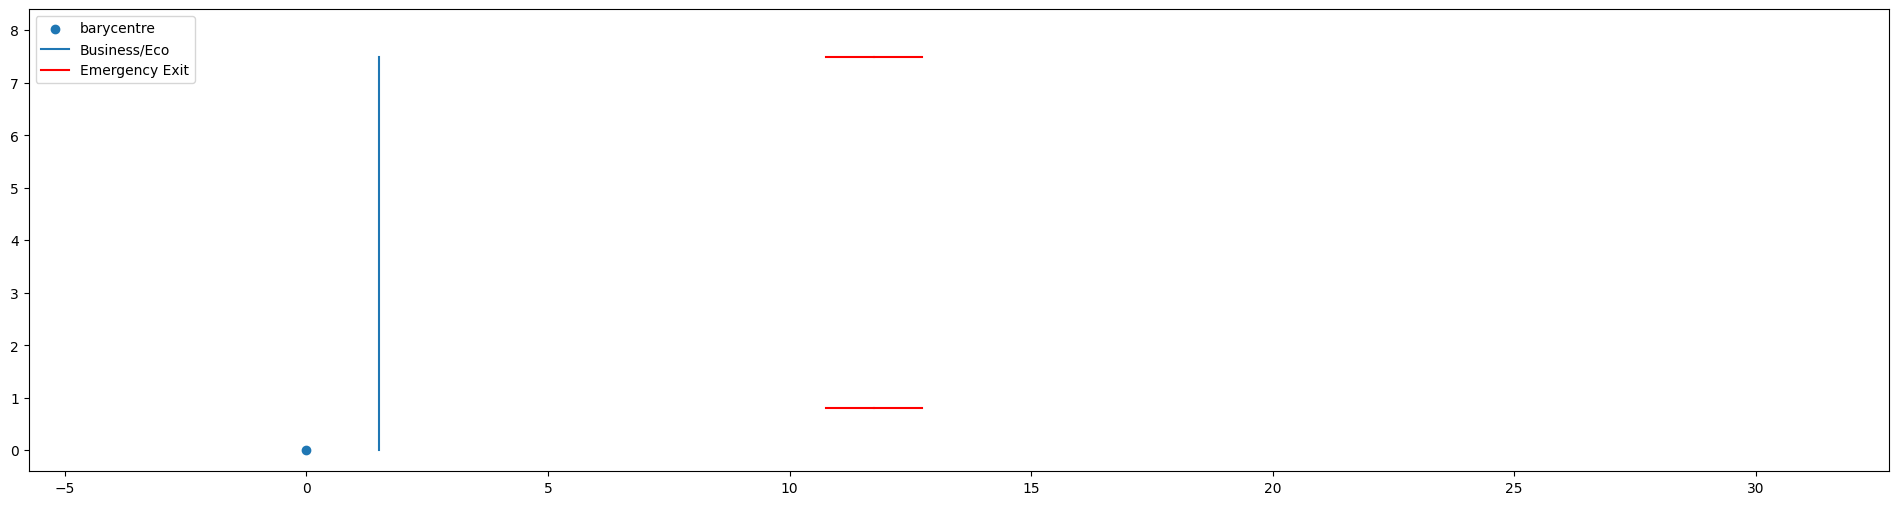

In [149]:
display_positions(create_dict_display(dict_attributions))

In [150]:
dict_copy = {x:dict_attributions[x] for x in dict_attributions}

### Heuristic approach

In [151]:
import random
"""
arguments : 
passenger_sheet
group_dict
attributions
"""

def score_group(group_nb, group_dict, dict_attributions):
    """
    Computes a group's score (the ultimate goal being to minimize the sum of scores)
    """
    score = 0
    n = len(group_dict[group_nb])
    for i in range(n):
        for j in range(i+1,n):
            rowi, seati = dict_attributions[group_dict[group_nb][i]]
            rowj, seatj = dict_attributions[group_dict[group_nb][j]]
            if rowi==rowj:
                score += 30* (abs(seati-seatj)-2)
            else:
                score += (50*abs(rowi-rowj) + abs(seati-seatj))
    return score

def create_group_scores(group_dict, dict_attributions):
    """
    Computes the score for all groups
    """
    scores = {}
    total_score = 0
    for i in group_dict.keys():
        s=score_group(i, group_dict, dict_attributions)
        total_score+=s
        scores[i]=s
    scores[-1]=total_score
    return scores

def has_civ(passenger):
    gr_num = passenger_sheet[passenger]['groupnr']
    for i in groups[gr_num]:
        if passenger_sheet[i]['cat'] == "WCHB":
            return True
    return False
        

def candidates(passenger_sheet, group_dict):
    """
    Returns clues for adult and business class passengers, then those in a group of at least 2 people
    """
    candidates=[[],[]]
    for i in passenger_sheet.keys():
        if passenger_sheet[i]['cat'] in ['h', 'f'] and passenger_sheet[i]['class']==0:
            candidates[0].append(i)
            if len(group_dict[passenger_sheet[i]['groupnr']])>=2:
                candidates[1].append(i)
    return candidates



def barycentre(attributions):
    row = sum([attributions[i][0]*mass(i, passenger_sheet) for i in attributions.keys()])/sum([mass(i, passenger_sheet) for i in attributions.keys()])
    seat = sum([attributions[i][1]*mass(i, passenger_sheet) for i in attributions.keys()])/sum([mass(i, passenger_sheet) for i in attributions.keys()])
    return (row,seat)

def barycentre_constraint(attributions):
    row,seat = barycentre(attributions)
    return(limit['inf']['row']<=row and limit['sup']['row'] >= row and limit['inf']['seat']<=seat and limit['sup']['seat']>=seat)

empty_seats = {i: {j:True for j in range(1,nb_seats_in_row+2)} for  i in range(1,nb_rows+1)} #is only used to build the list of empty seats
for i in range(nb_passengers):
    empty_seats[dict_attributions[i][0]][dict_attributions[i][1]] = False
    if passenger_sheet[i]['cat'] == 'WCHB':
        for a in range(-1,3):
            for b in range(-1,2):
                empty_seats[dict_attributions[i][0]+a][dict_attributions[i][1]+b] = False
for i in empty_seats.keys():
    if i<= nb_business_seat//4:
        for j in empty_seats[i].keys():
            empty_seats[i][j]=False


empty_seats_list = []
for i in empty_seats.keys():
    for j in empty_seats[i].keys():
        if empty_seats[i][j] and j!=4 and i>nb_business_seat//4:
            empty_seats_list.append((i,j))


def mutation(solution, group_dict, passenger_sheet):
    """
    solution : [allocations, scores, candidates, empty_seats]
    choice = 1: Swap two swappable passengers, and keep the solution if the score of one of the groups has improved
    choice = 2: Places a passenger in an empty seat, and keeps the solution if his group's score has improved
    """
    attributions = solution[0]
    new_attr = {i:attributions[i] for i in attributions.keys()}
    scores = solution[1]
    new_scores = {i:scores[i] for i in scores.keys()}
    candidates = solution[2]
    empty = solution[3].copy()
    choice = random.randint(1,2)
    i2 = random.randint(0,len(candidates[1])-1)
    c2 = candidates[1][i2]
    if choice==1:
        i1 = random.randint(0,len(candidates[0])-1)
        c1 = candidates[0][i1]
        new_attr[c1], new_attr[c2]=attributions[c2], attributions[c1]
        gr1 = passenger_sheet[c1]['groupnr']
        gr2 = passenger_sheet[c2]['groupnr']
        new_scores[gr1] = score_group(gr1, group_dict, new_attr)
        new_scores[gr2] = score_group(gr2, group_dict, new_attr)
        if barycentre_constraint(new_attr) and (new_scores[gr1]<scores[gr1] or new_scores[gr2]<scores[gr2]):
            new_scores[-1]+= (new_scores[gr1] - scores[gr1]) + (new_scores[gr2] - scores[gr2])
            return [new_attr, new_scores, candidates, empty]
        else:
            return new_scores[-1]
    else:
        id_vide = random.randint(0,len(empty)-1)
        el = empty[id_vide]
        empty.append(attributions[c2])
        new_attr[c2] = empty[id_vide]
        empty.remove(el)
        gr2 = passenger_sheet[c2]['groupnr']
        new_scores[gr2] = score_group(gr2, group_dict, new_attr)
        if barycentre_constraint(new_attr) and (new_scores[gr2]<scores[gr2]):
            new_scores[-1]+= (new_scores[gr2] - scores[gr2])
            return [new_attr, new_scores, candidates, empty]
        else:
            return new_scores[-1]
    
def keep_n_best(n, generation):
    """ 
    takes the n best elements of a generation
    """
    tri = generation
    tri.sort(key= lambda sol: sol[1][-1])
    return tri[0:n]

    
def new_generation(group_dict, solution, passenger_sheet, nb_child, limit):
    """
    creates a new generation from an individual by applying a mutation
    """
    new_gen = [solution]
    iter = 0
    while len(new_gen)<nb_child and iter<limit:
        mutated = mutation(solution, group_dict, passenger_sheet)
        if type(mutated)!=int:
            new_gen.append(mutated)
        iter+=1
    return new_gen

def heuristique(group_dict, dict_attributions, passenger_sheet, nb_childs, limitc, limitg, limitf):
    """
    Creates generations before selecting the best individual for the next generation;
    limitc: maximum number of mutation attempts per generation;
    limitg: maximum number of generations;
    limitf: maximum number of successive generations without score improvement.
    """
    candidate = candidates(passenger_sheet, group_dict)
    scores = create_group_scores(group_dict, dict_attributions)
    print('Score initial : ' + str(scores[-1]))
    solution = [dict_attributions, scores, candidate, empty_seats_list]
    gen = [solution]
    iter = 0
    best_score = gen[0][1][-1]
    failures = 0
    display_ = 1 # used for display
    while iter<limitg:
        iter += 1
        if int(display_*limitg/20)==iter:
            print('Generation number ' + str(iter) + '  (' + str(5*display_) + '%)')
            display_+=1
        for sol in gen:
            gen = gen + new_generation(group_dict, sol, passenger_sheet, nb_childs, limitc)
        gen = keep_n_best(nb_childs, gen) # 1 can be replaced by nb_children
        temp_score = keep_n_best(1, gen)[0][1][-1]
        if temp_score==best_score:
            failures += 1
            print('fails : ' + str(failures) + '/'+str(limitf))
        else:
            failures = 0
        if failures == limitf:
            return keep_n_best(nb_childs, gen)[0]
    print('--- GENERATION LIMIT REACHED ---')
    return keep_n_best(nb_childs, gen)[0]

            

KeyError: 0

In [ ]:
group_dict = {i:[personne for personne in groups[i]] for i in groups}
score_init = create_group_scores(group_dict, dict_attributions)[-1]
    

if correction_needed:
    result = heuristique(group_dict, dict_attributions, passenger_sheet, 4, 500, 20,20)
else:
    result = [dict_attributions, create_group_scores(group_dict, dict_attributions), candidates(passenger_sheet, group_dict)]

score_final = result[1][-1]
print('Final Score: ' + str(score_final))
print('Improvment of ' + str((score_init-score_final)/score_init*100) + '%')


Score initial : 12392
Generation number 1  (5%)
Generation number 2  (10%)
Generation number 3  (15%)
Generation number 4  (20%)
Generation number 5  (25%)
Generation number 6  (30%)
Generation number 7  (35%)
Generation number 8  (40%)
Generation number 9  (45%)
Generation number 10  (50%)
Generation number 11  (55%)
Generation number 12  (60%)
Generation number 13  (65%)
Generation number 14  (70%)
Generation number 15  (75%)
Generation number 16  (80%)
Generation number 17  (85%)
Generation number 18  (90%)
Generation number 19  (95%)
Generation number 20  (100%)
--- GENERATION LIMIT REACHED ---
Final Score: 10497
Improvment of 15.292123950936087%


In [152]:
display_positions(create_dict_display(result[0]))

KeyError: 164

## Dynamic

In [ ]:
group_update = {i:True for i in group_dict}
for i in group_update:
    if (group_sheet[i]['WCHR']+group_sheet[i]['WCHB'])>0:
        group_update[i]=False


def permutlist(seq, err=False):
    """
    Returns the list of all permutations of the seq list (non-recursive).
    If err=True: eliminates repetitions when seq has them (e.g. [1,2,2]
    """
    p = [seq]
    n = len(seq)
    for k in range(0,n-1):
        for i in range(0, len(p)):
            z = p[i][:]
            for _ in range(0,n-k-1):
                z.append(z.pop(k))
                if err==False or (z not in p):
                    p.append(z[:])
    return p


def arranglist(seq):
    """
    List of arrangements of seq list objects taken k to k
    """
    p = []
    i, imax = 0, 2**len(seq)-1
    while i<=imax:
        s = []
        j, jmax = 0, len(seq)-1
        while j<=jmax:
            if (i>>j)&1==1:
                s.append(seq[j])
            j += 1
        if len(s)==len(seq):
            v = permutlist(s)
            p.extend(v)
        i += 1 
    return p

# print(arranglist([1,2,3,4]))


def exchange_barycentre(id_sujet, id_target, dict_reservations):
    gr1 = group_dict[id_sujet]
    gr2 = group_dict[id_target]
    for gr1 in arranglist(group_dict[id_sujet]):
        for gr2 in arranglist(group_dict[id_target]):
            temp_dict = {i:dict_reservations[i] for i in dict_reservations}
            for i in range(len(gr1)):
                temp_dict[gr1[i]],temp_dict[gr2[i]] = temp_dict[gr2[i]],temp_dict[gr1[i]]
            if barycentre_constraint(temp_dict):
                return_dict = {}
                for i in range(len(gr1)):
                    return_dict[gr1[i]] = temp_dict[gr1[i]]
                    return_dict[gr2[i]] = temp_dict[gr2[i]]
                return return_dict



def dynamic_placement():
    dict_reservations = {i:result[0][i] for i in result[0]}
    order_reservation=list()
    for key in group_update:
        if group_update[key]:
            order_reservation.append(key)
    rd.shuffle(order_reservation)
    for id_group in order_reservation:
        list_choice = []
        for g in group_dict:
            if group_update[g] and (length_of_group(group_sheet[id_group]) == length_of_group(group_sheet[g])) and group_sheet[id_group]['class']==group_sheet[g]['class'] and ((group_sheet[g]['transit_time']>0)==(group_sheet[id_group]['transit_time']>0)):
                new_seats = exchange_barycentre(id_group,g, dict_reservations)
                if new_seats:
                    list_choice.append(new_seats) # new_seats : {person_id: new place for person in (both groups)}
        nv_id=rd.randint(0,len(list_choice)-1) # one possibility is chosen at random here, but this is the stage where the group chooses its seat from among the possibilities
        
        new_seats_list = list_choice[nv_id]
        print_seats = []
        for id_p in new_seats_list:
            print_seats.append(new_seats_list[id_p])
            dict_reservations[id_p] = new_seats_list[id_p]
        group_update[id_group] = False
        print('The group ' + str(id_group) + ' has chosen seat :')
        print(print_seats)
    return dict_reservations
show = dynamic_placement()

The group 58 has chosen seat :
[(22, 7), (27, 2)]
The group 31 has chosen seat :
[(23, 6), (16, 6)]
The group 115 has chosen seat :
[(10, 3), (16, 7)]
The group 62 has chosen seat :
[(21, 5), (7, 6), (21, 6), (7, 5)]
The group 41 has chosen seat :
[(17, 7), (26, 5)]
The group 113 has chosen seat :
[(13, 1), (15, 7)]
The group 21 has chosen seat :
[(20, 5), (22, 3)]
The group 87 has chosen seat :
[(10, 1), (24, 6)]
The group 91 has chosen seat :
[(30, 3), (20, 7)]
The group 16 has chosen seat :
[(21, 2), (29, 7)]
The group 24 has chosen seat :
[(12, 5), (28, 6)]
The group 82 has chosen seat :
[(12, 3), (25, 1)]
The group 48 has chosen seat :
[(26, 5), (27, 3)]
The group 3 has chosen seat :
[(24, 7), (17, 5)]
The group 85 has chosen seat :
[(21, 1), (23, 2)]
The group 60 has chosen seat :
[(16, 3), (29, 7)]
The group 70 has chosen seat :
[(25, 5), (20, 2)]
The group 57 has chosen seat :
[(30, 5), (20, 1)]
The group 97 has chosen seat :
[(23, 3), (23, 1)]
The group 109 has chosen seat :
[

MemoryError: 

Layout found by the optimization algorithm :

the barycentre is at rank 16.540499621498864 and in seat 3.996214988644966


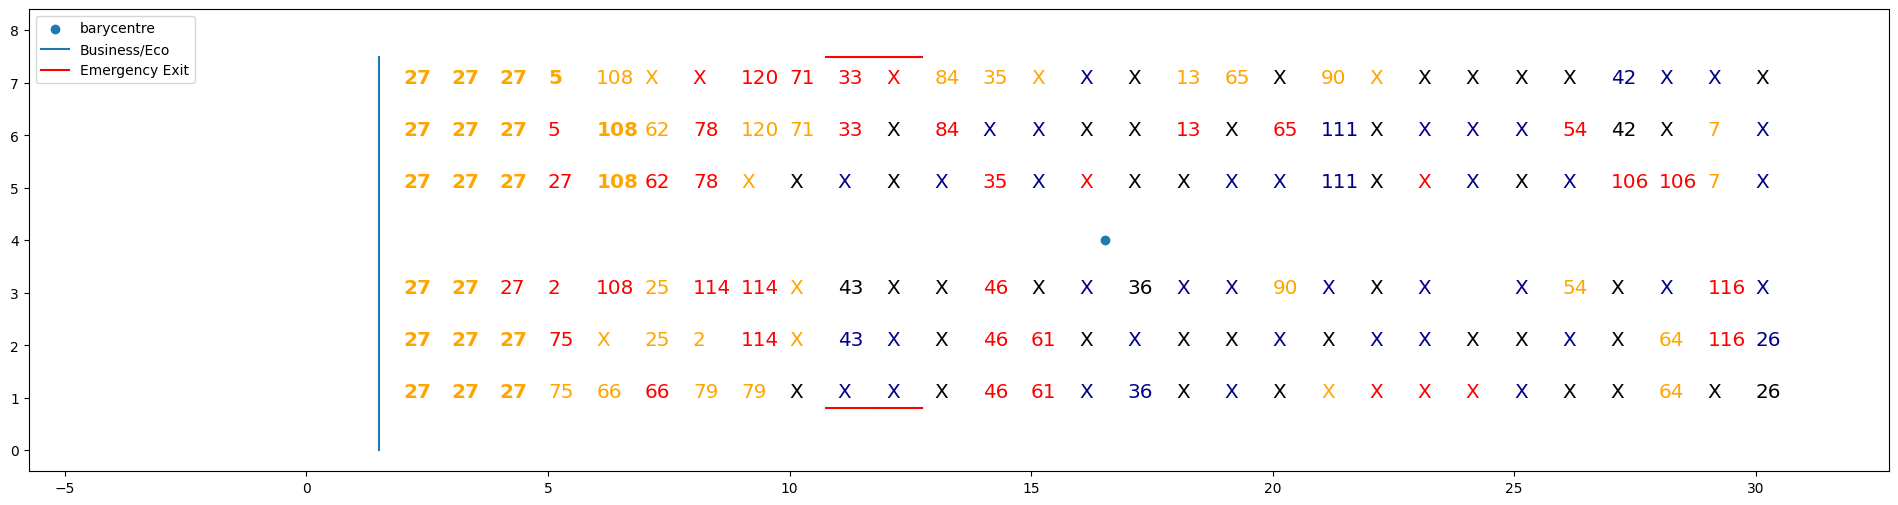

In [ ]:
display_positions(create_dict_display(result[0]))

Layout chosen by passengers :

the barycentre is at rank 14.885683760683762 and in seat 3.826923076923077


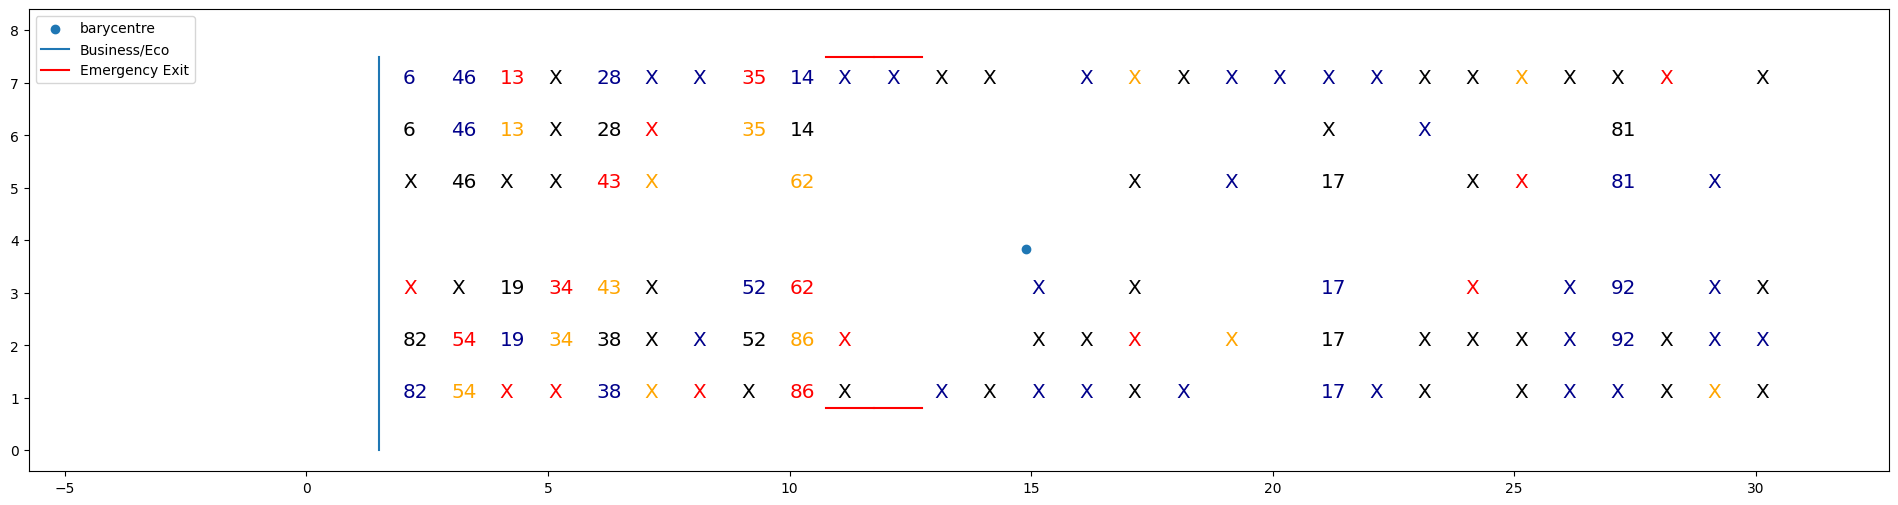

In [ ]:
display_positions(create_dict_display(show))

On the diagram displayed above when running the code :
- the blue dot represents the aircraft's barycenter;
- the Xs represent single passengers;
- groups are displayed by number;
- fast-transit passengers are shown in red for women and orange for men;
- other passengers are shown in black for women and blue for men;
- children are marked in bold;
- wheelchairs are displayed with a green rectangle symbolizing the space occupied;
- stretchers are displayed with a purple rectangle symbolizing occupied space;
- ghost passengers are no longer displayed.